In [1]:
import pandas as pd

brent_oil_df_raw = pd.read_csv("data/GasOtherFutures/individual_data/Brent_Crude_Oil_data.csv")
display(brent_oil_df_raw)

,date,open,high,low,close,volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,4387
...,...,...,...,...,...,...
4130,2024-03-19,86.849998,87.709999,86.489998,87.379997,30045
4131,2024-03-20,87.220001,87.349998,85.580002,85.949997,35304
4132,2024-03-21,86.160004,86.639999,85.050003,85.779999,23829
4133,2024-03-22,85.550003,86.150002,85.110001,85.430000,14778


In [2]:
import numpy as np

data = np.full((brent_oil_df_raw['date'].size, 2), np.nan)
columns = ['Original', 'Predicted']
brent_oil_close_df = pd.DataFrame(
    data,
    index=pd.to_datetime(brent_oil_df_raw['date']),
    columns=columns)
brent_oil_close_df['Original'] =\
    brent_oil_df_raw['close'].to_numpy()
brent_oil_close_df

,Original,Predicted
date,,
2007-07-30,75.739998,NaN
2007-07-31,77.050003,NaN
2007-08-01,75.349998,NaN
2007-08-02,75.760002,NaN
2007-08-03,74.750000,NaN
...,...,...
2024-03-19,87.379997,NaN
2024-03-20,85.949997,NaN
2024-03-21,85.779999,NaN


In [3]:
# Using business day frequency
brent_oil_close_df = brent_oil_close_df.asfreq('B')
brent_oil_close_df.interpolate('time', inplace=True)
brent_oil_close_df

,Original,Predicted
date,,
2007-07-30,75.739998,NaN
2007-07-31,77.050003,NaN
2007-08-01,75.349998,NaN
2007-08-02,75.760002,NaN
2007-08-03,74.750000,NaN
...,...,...
2024-03-19,87.379997,NaN
2024-03-20,85.949997,NaN
2024-03-21,85.779999,NaN


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.722, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=271.314, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=271.644, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=273.256, Time=0.02 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=274.741, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=275.637, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=271.409, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=271.190, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=272.809, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=274.801, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=276.442, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=272.097, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=272.822, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=274.801, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] inter

<Axes: xlabel='date'>

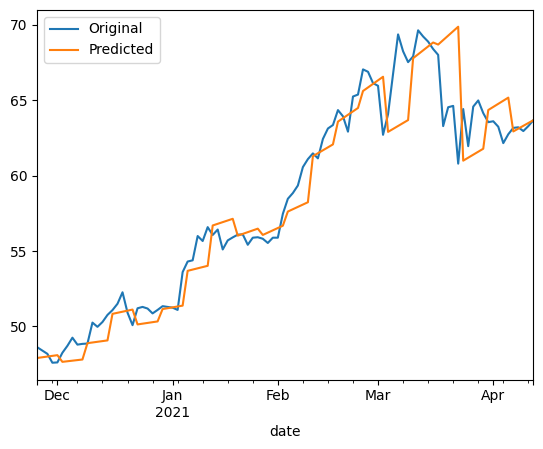

In [5]:
from pmdarima.arima import auto_arima

class IterativeARIMA:
    def __init__(
            self,
            data: pd.Series,
            num_steps: int,
            invalidate_size: int,
            n_fit: int,
            test_split: float,):
        assert 0 <= test_split <= 1
        self.test_size = int(len(data) * test_split)
        self.train_size = len(data) - self.test_size
        assert num_steps <= self.test_size
        assert 0 < invalidate_size < self.train_size
        assert n_fit <= self.train_size
        self.data = data
        self.invalidate_size = invalidate_size
        self.n_fit = n_fit
        self.num_steps = num_steps
        fit_df = self._get_fit_df(0)
        self.model = auto_arima(
            y=fit_df,
            x=fit_df.index,
            start_p=1, start_q=1,
            max_p=10, max_q=10,
            seasonal=False,
            stepwise=False,
            trace=True
        )
        self.pred_df = pd.Series(
            np.full(num_steps, np.nan),
            index=self.data.index[self.train_size : self.train_size + num_steps]
        )
        self.step = 0

    def _get_fit_df(self, offset: int | None = None):
        if offset is None:
            offset = self.step
        end = self.train_size + offset
        start = end - self.n_fit
        return self.data[start:end]

    def __iter__(self):
        return self

    def __next__(self):
        if self.step >= self.num_steps:
            raise StopIteration
        if self.step % self.invalidate_size == 0:
            self.model.fit(self._get_fit_df())
        n_periods = min(self.invalidate_size, self.num_steps - self.step)
        predict = self.model.predict(n_periods=n_periods)
        self.pred_df.update(predict)
        if self.invalidate_size == 1:
            print(f"Step {self.step} of {self.num_steps}")
        else:
            print(f"Step {self.step} to {self.step + n_periods} of {self.num_steps}")
        self.step += self.invalidate_size
        return self.pred_df[:self.step]
    
    def get_comparison_df(self):
        df = pd.DataFrame({
            'Original': self.data[self.train_size : self.train_size + self.num_steps],
            'Predicted': self.pred_df
        })
        return df
    
iter_arima = IterativeARIMA(brent_oil_close_df['Original'], 100, 5, 100, 0.2)
for pred in iter_arima:
    pass
iter_arima.get_comparison_df().plot()